In [1]:
# import libraries
#import torch

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

In [2]:
import gzip
import os
from urllib.request import urlretrieve
import numpy as np
from matplotlib import image

def mnist(path=None):
    r"""Return (train_images, train_labels, test_images, test_labels).

    Args:
        path (str): Directory containing MNIST. Default is
            /home/USER/data/mnist or C:\Users\USER\data\mnist.
            Create if nonexistant. Download any missing files.

    Returns:
        Tuple of (train_images, train_labels, test_images, test_labels), each
            a matrix. Rows are examples. Columns of images are pixel values.
            Columns of labels are a onehot encoding of the correct class.

    url = 'http://yann.lecun.com/exdb/mnist/'
    files = ['train-images-idx3-ubyte.gz',
             'train-labels-idx1-ubyte.gz',
             't10k-images-idx3-ubyte.gz',
             't10k-labels-idx1-ubyte.gz']
    """
    if path is None:
        # Set path to /home/USER/data/mnist or C:\Users\USER\data\salt
        path = os.path.join(os.path.expanduser('~/'), 'data', 'salt')

    # Create path if it doesn't exist
    #os.makedirs(path, exist_ok=True)
    """"
    # Download any missing files
    for file in files:
        if file not in os.listdir(path):
            urlretrieve(url + file, os.path.join(path, file))
            print("Downloaded %s to %s" % (file, path))
    print("All files are ready to gzip!")
    """
    def _images(path):
        """Return images loaded locally."""
        folder = path + "/images/"
        onlyfiles = [cv2.resize(cv2.cvtColor(image.imread(folder+f), cv2.COLOR_RGB2GRAY),(32, 32)) for f in os.listdir(folder)]
        pixels = np.array(onlyfiles).reshape(-1,1,32,32).astype('float32')#/255
        return pixels[:1,:,:,:]

    def _labels(path):
        """Return labels loaded locally."""
        
        folder = path + "/labels/"
        onlyfiles = [cv2.resize(cv2.cvtColor(image.imread(folder+f), cv2.COLOR_RGB2GRAY),(32, 32)) for f in os.listdir(folder)]
        #onlyfiles = [cv2.resize(image.imread(folder+f),(32, 32)) for f in os.listdir(folder)]
        pixels = np.array(onlyfiles).reshape(-1,1,32,32).astype('float32') #/255
        return pixels[:1,:,:,:]
    print("Train Images : Loading . . .")
    train_images = _images(path)
    print("Train Labels : Loading . . .")
    train_labels = _labels(path)
    """"
    print("Test Images  : Loading . . .")
    test_images = _images(os.path.join(path, files[2]))
    print("Test Labels  : Loading . . .")
    test_labels = _labels(os.path.join(path, files[3])) 
    """
    print("Done!")
    return train_images, train_labels #, test_images, test_labels

In [3]:
train_images, train_labels= mnist()  #, test_images, test_labels 

Train Images : Loading . . .
Train Labels : Loading . . .
Done!


In [4]:
ch = 1 #Number of channels
#train_images=cv2.resize(train_images[0,:,:], (32,32)).reshape(1,1,32,32)
print(train_images.shape)
#train_labels = train_images
print(train_labels.shape) # ONE-HOT !!!
#print(train_images.T.shape)
#print(train_labels.reshape((train_images.shape[0], 10)).shape)

##### Getting Ready for the Conv Layers #####
#train_images = train_images.reshape(train_images.shape[0], ch, 28, 28).squeeze()
#test_images = test_images.reshape(test_images.shape[0], ch, 28, 28).squeeze()

#############################################

#y = train_images[1].reshape(1,28,28)
#print(y.squeeze().shape)
'''
temp = []
#train_labels = train_labels.sum(1)
for i in range(int(len(train_labels[:]))):
    temp.append(list(train_labels[i][:]).index(1))
    
    
train_labels = np.array(temp.copy())
#print(train_labels[0:5])
'''
#plt.imshow(train_images[0].squeeze(), cmap='Greys_r');
pass

(1, 1, 32, 32)
(1, 1, 32, 32)


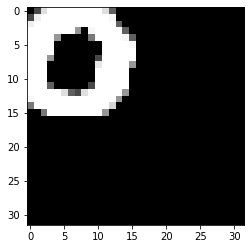

In [5]:
plt.imshow(train_labels[0].squeeze(), cmap=plt.get_cmap('gray'), vmin=0, vmax=1);


In [6]:
########### Convolution Architecture - Downsampling/Upsampling  ##################

def init_filters(layers, init_n_f ,trim):
    filters = []
    bias = []
    f_dc = []
    
    trimf = trim
    trimb = trim*5
    n_f = init_n_f #initial number of filters/kernels
    ch_in = 1      #input channels
    """
    for i in range(layers):
        if(i != 0):
            n_f = n_f*2 #16,32,64,128,256
        #f1 shape : (num_filters,input channels, f_h, f_w)
        f1 = (n_f, ch_in, 3, 3)
        f1 = np.random.randn(n_f, ch_in, 3, 3) *trimf
        b1 = np.random.randn(f1.shape[0],1)* trimb
        ch_in = n_f
        f2 = (n_f, ch_in, 3, 3)
        f2 = np.random.randn(n_f, ch_in, 3, 3) *trimf
        b2 = np.random.randn(f2.shape[0],1)* trimb
        f = [f1, f2]
        b = [b1, b2]
        filters.append(f)
        bias.append(b)
    
    #Deconvolution filters    
    for i in range(1,layers):
        n_f = n_f//2 #128,64,32,16
        #f1 shape : (num_filters,input channels, f_h, f_w)
        fdc = np.random.randn(n_f,ch_in,2,2)*trimf #upsampling filter, its result will be conc with conv4 output so the channels will be doubled again
        bdc = np.random.randn(fdc.shape[0],1)* trimb
        f1 = (n_f, ch_in, 3, 3)
        f1 = np.random.randn(n_f, ch_in, 3, 3) *trimf
        b1 = np.random.randn(f1.shape[0],1)* trimb
        ch_in = n_f
        f2 = (n_f, ch_in, 3, 3)
        f2 = np.random.randn(n_f, ch_in, 3, 3) *trimf
        b2 = np.random.randn(f2.shape[0],1)* trimb
        f = [f1, f2]
        b = [b1, b2]
        dc = [fdc, bdc]
        filters.append(f)
        bias.append(b)
        f_dc.append(dc)
        
    """
    trimbr = trim
    locbr = 0
    for i in range(layers):
        if(i != 0):
            n_f = n_f*2 #16,32,64,128,256
        #f1 shape : (num_filters,input channels, f_h, f_w)
        f1 = (n_f, ch_in, 3, 3)
        f1 = np.random.normal(loc = locbr, scale = trimbr , size = f1) #np.random.randn(n_f, ch_in, 3, 3) *trimf
        b1 = np.random.normal(loc = locbr, scale = trimbr , size = (f1.shape[0],1)) #np.random.randn(f1.shape[0],1)* trimb
        ch_in = n_f
        f2 = (n_f, ch_in, 3, 3)
        f2 = np.random.normal(loc = locbr, scale = trimbr , size = f2)
        b2 = np.random.normal(loc = locbr, scale = trimbr , size = (f2.shape[0],1))
        f = [f1, f2]
        b = [b1, b2]
        filters.append(f)
        bias.append(b)
    
    #Deconvolution filters    
    for i in range(1,layers):
        n_f = n_f//2 #128,64,32,16
        #f1 shape : (num_filters,input channels, f_h, f_w)
        fdc =  np.random.normal(loc = locbr, scale = trimbr , size = (n_f,ch_in,2,2))#upsampling filter, its result will be conc with conv4 output so the channels will be doubled again
        bdc = np.random.normal(loc = locbr, scale = trimbr , size = (fdc.shape[0],1))
        f1 = (n_f, ch_in, 3, 3)
        f1 = np.random.normal(loc = locbr, scale = trimbr , size = (n_f, ch_in, 3, 3))
        b1 = np.random.normal(loc = locbr, scale = trimbr , size = (f1.shape[0],1))
        ch_in = n_f
        f2 = (n_f, ch_in, 3, 3)
        f2 = np.random.normal(loc = locbr, scale = trimbr , size = f2)
        b2 = np.random.normal(loc = locbr, scale = trimbr , size = (f2.shape[0],1))
        f = [f1, f2]
        b = [b1, b2]
        dc = [fdc, bdc]
        filters.append(f)
        bias.append(b)
        f_dc.append(dc)
    return filters, bias, f_dc    

In [7]:
### Activation Functions ###
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def relu(Z):
    return np.maximum(0,Z)

def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def relu_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0;
    return dZ;

In [8]:
########## UTILITIES #############

def conv(image, params, s = 1, pad = 1 ): # s = 1 (conv stride)
    #f1 shape : (num_filters,input channels, f_h, f_w)
    #image shape: (channels, height, width)
    [f, b] = params
    if(pad >= 1):
        tmp = np.zeros((image.shape[0],image.shape[1]+2*pad ,image.shape[2]+2*pad))
        tmp[:,pad:-pad,pad:-pad] = image
        image = tmp    
        
    f_num = f.shape[0]
    f_depth = f.shape[1] #f1 = 1 , f2 = 8
    f_size = f.shape[2] 
        

    h_range = int((image.shape[1] - f_size) / s) + 1     # (W - F + 2P) / S  
    w_range = int((image.shape[2] - f_size) / s) + 1     # (W - F + 2P) / S  
    np_o = np.zeros((f_num, h_range, w_range))
    for z in range(f_num): # Number of filters
        for _h in range(h_range):      
            for _w in range(w_range):
                np_o[z, _h, _w] = np.sum(np.multiply(image[:, _h*s : _h*s + f_size, _w*s : _w*s + f_size] , f[z, :, :, :])) + b[z]
    
    return np_o

def convolutionBackward(dconv_prev, conv_in, filt, s = 1, pad = 1 ):
    #filt =np.rot90(filt, 2)  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!! A T T E N T I O N !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    f_num, n_c, f, _ = filt.shape
    
    _ ,h , w = dconv_prev.shape
    dfilt = np.zeros(filt.shape)
    if(pad >= 1):
        tmp = np.zeros((conv_in.shape[0],conv_in.shape[1]+2*pad ,conv_in.shape[2]+2*pad))
        tmp[:,pad:-pad,pad:-pad] = conv_in
        conv_in = tmp
    
    dconv_in = np.zeros(conv_in.shape)
    db = np.zeros((f_num,1))

    for z in range(f_num): # Number of filters
        for _h in range(h):      
            for _w in range(w):
                #each entry of the dconv_prev will try to affect the idxs from which was made of.
                dfilt[z] += dconv_prev[z, _h, _w] * conv_in[:, _h*s : _h*s + f, _w*s : _w*s + f]
                dconv_in[:, _h*s : _h*s + f, _w*s : _w*s + f] += dconv_prev[z, _h, _w] * filt[z]  
        db[z] = np.sum(dconv_prev[z])  #, axis =1) ## AXIS?
    
    if(pad >=1 ):
        dconv_in = dconv_in[:, pad:-pad, pad:-pad]  # Cropping
        
    return dconv_in, dfilt, db

def convTransp1(image, params, s = 2, pad = 1):
    [f, b] = params
    n_f, n_c, f_s, _ = f.shape
    input_s = image.shape[1]
    target_dim = input_s*2
    res = np.zeros((n_f, target_dim, target_dim))
    temp =np.zeros((n_c, target_dim, target_dim))
    for z in range(n_f):
        for _h in range(input_s):      
            for _w in range(input_s):
                temp[:, _h*s:_h*s+f_s, _w*s:_w*s+f_s] += image[:, _h, _w].reshape(n_c,1,1)*f[z,:,:,:] #bias will be added at the end
        res[z] = np.sum(temp , axis = 0) + b[z]
    return res, image

def convTranspBackward1(dconv_prev, new_in, filt, s = 2):
    n_f, n_c, f_s, _ = filt.shape
    _, input_s, _ = new_in.shape
    #final_dim = (new_in.shape[1] - 2)//2 + 1 
    dc_s=dconv_prev.shape[1]
    temp = np.zeros((n_c,dc_s,dc_s))
    dfilt = np.zeros(filt.shape)
    dconv_in = np.zeros(new_in.shape)
    db = np.zeros((n_f,1))
    for z in range(n_f):
        for _h in range(input_s):      
            for _w in range(input_s): 
                dfilt[z] += dconv_prev[z, _h*s:_h*s+f_s, _w*s:_w*s+f_s]*new_in[:,_h,_w].reshape(n_c,1,1)
                temp[:, _h*s:_h*s+f_s, _w*s:_w*s+f_s] += dconv_prev[z, _h*s:_h*s+f_s, _w*s:_w*s+f_s] * filt[z]
                for ch in range(n_c):
                    dconv_in[ch, _h, _w] += np.sum(temp[ch, _h*s:_h*s+f_s, _w*s:_w*s+f_s])
        db[z] = np.sum(dconv_prev[z])        
    return dconv_in, dfilt, db

    
def convTransp(image, params, s = 1, pad = 1):
    #s is always 1, upsample kernel = 2
    #zero insertions between pixels s_downsampled -1 = 2-1 = 1
    #required padding in order to double my dimensions with the given data:
    #(i-1)*2 + k -2p = output size, where our padding is k - p -1 = 2-0-1=1(we assume p=0)
    [f, b]=params
    f = np.rot90(f, 1, (2,3))
    params = [f, b]
    input_s = image.shape[1]
    target_dim = input_s*2 #final dim, after conv
    required_pad = 1 #always for filter 2x2 ,stride 1, zero insertion 1 and main target to double dim
    #make our new custom input
    size = input_s*2 +1
    new_in = np.zeros((image.shape[0], size, size))
    
    ### OR just: np.pad(image[:,:,:],2,'constant') # Important, we must loop with respect to the 1st dim
    for i in range(1, target_dim, 2):
        for j in range(1, target_dim, 2):
                new_in[:, i, j] = image[:, i//2, j//2]
    #now we do a normal convolution(pad = 0)
    res = conv(new_in, params, 1, 0) #thats the final result with target_dim
    return res, new_in # we will need new_in so we wont calc it again for the backprop
    
def convTranspBackward(dconv_prev, new_in, filt, s = 1):
    #First, we do a backward convolution on new_in,d_conv_prev,
    #then we will choose form the d_conv_new the entries that match the initial 'smaller' input image
    #by selecting the odd matrix cells 1,3,5... because we had applied a standard pad=1,zero inser=1
    dconv_in, dfilt, db = convolutionBackward(dconv_prev, new_in, filt,1,0)
    #Now its time to choose the right entries to build the gradients of the initial input image
    dim = dconv_in.shape[1]
    final_dim = (new_in.shape[1] - 2)//2 + 1 #based on dimen of image before final conv that gives the result,..
    #e.g. for new_in 7x7 that is going to convoluted with a 2x2 kernel and give a 6x6 upsampled from 3x3 init image
    # now from this 7x7 --> apply the formula above,we get the 3x3 dimension number
    res = np.zeros((dconv_in.shape[0], final_dim, final_dim))
    for i in range(1, dim, 2):
        for j in range(1, dim, 2):
                res[:, i//2, j//2] = dconv_in[:, i, j]
    return res, dfilt, db
    
    
def maxpool(image, f=2 , s=2):
    
    h_range = int((image.shape[1] - f) / s) + 1     # (W - F + 2P) / S  
    w_range = int((image.shape[2] - f) / s) + 1     # (W - F + 2P) / S 
    out = np.zeros((image.shape[0], h_range, w_range))
    
    for z in range(image.shape[0]): # Number of channels
        for _h in range(h_range):      
            for _w in range(w_range):
                out[z, _h, _w] = np.max(image[z, _h*s : _h*s + f, _w*s : _w*s + f])
    return out

def nanargmax(arr):
    #print(arr.shape)
    try:
        idx = np.nanargmax(arr)
        #print (idx)
    except:
        idx = 0
    idxs = np.unravel_index(idx, arr.shape)
    return idxs 

def maxpoolBackward(dpool, conv, f=2 , s=2):
    num_c, h, w = conv.shape
    h = int((h - f) / s) + 1     # (W - F + 2P) / S  
    w = int((w - f) / s) + 1     # (W - F + 2P) / S 
    
    dout = np.zeros(conv.shape)
    #print(conv.shape)
    for z in range(num_c): # Number of channels
        for _h in range(h):      
            for _w in range(w):
                (a, b) = nanargmax(conv[z, _h*s : _h*s + f, _w*s : _w*s + f]) #Getting the indexes from the max value in this area
                #put it on the new array
                dout[z, _h + a, _w + b] = dpool[z, _h, _w]
    
    
    return dout


def reshape(img, reshape_dim):
    pad = reshape_dim - img.shape[1]
    if(pad == 0):
        return img
    res = np.zeros((img.shape[0], reshape_dim, reshape_dim))
    if(pad > 1):
        res[:, pad//2:-(pad//2), pad//2:-(pad//2)] = img
    else:
        res[:, 0:-(pad), 0:-(pad)] = img
    return res


def crop(img, crop_dim): #TODO : look at it..future upgrade to downsample..maybe
    start = img.shape[1]//2 - crop_dim//2
    return img[:,(start):(start +crop_dim),(start):(start +crop_dim)]

    
    
def crop2half(img):
    #return gradients for decoder side and gradients for encoder side
    n_ch = img.shape[0]//2
    return img[n_ch:n_ch*2 ,:,:], img[0:n_ch,:,:]
    
def concat(img1_true, img2):
    n_ch = img1_true.shape[0]
    dim = img1_true.shape[1]
    if(img2.shape[1] != dim):
        img2 = crop(img2, dim)
        print("Warning: Extra crop needed and handled!(%d --> %d)" %(dim, img2.shape[1]))
    res = np.zeros((n_ch*2, dim, dim))
    res[0:n_ch,:,:] = img2
    res[n_ch:n_ch*2 ,:,:] = img1_true
    return res



In [18]:
###### Cost Calculations ######
def Cross_Entropy(logs, targets):  # Pixel-Wise Cross entropy --> average accuracy
    out = np.zeros(logs.shape)
    mylen = logs.shape[0]*logs.shape[1]*logs.shape[2]
    #print(len(targets))
    #logs.shape (dim x dim) like target
    for i in range(logs.shape[1]):
        for j in range(logs.shape[2]):
            if(targets[:,i,j] >= logs[:,i,j]):#Gray and above
                out[:,i,j] = logs[:,i,j]/targets[:,i,j] 
            else:
                out[:,i,j] = (1 - logs[:,i,j])/(1 - targets[:,i,j]) # e.g if logs[i,j]= 0.4 and we want(target) 0 --> 1-0.4=0.6 prob. for zero 
    #or
    #out = targets*logs + ((-1*(targets-1)) - (-1*(targets-1))*logs)
    res =out.sum()/mylen
    return -np.log(res),res


def Dice_Coef(logs, targets):
    out = np.zeros(logs.shape)
    mylen = logs.shape[0]*logs.shape[1]*logs.shape[2]
    #Apply Dice coefficient
    numerator = (logs*targets)
    denominator = logs + targets
    loss = 1 - (2*np.sum(numerator))/(np.sum(denominator))
    return loss, np.exp(-loss)
                
    
    
def get_cost_value(Y_hat, Y):
    # number of examples
    m = Y_hat.shape[1]
    
    # calculation of the cost according to the formula
    cost = -1 / m * (np.dot(Y, np.log(Y_hat).T) + np.dot(1 - Y, np.log(1 - Y_hat).T))
    return np.squeeze(cost) ### ATTENTION!

def normalize(output):
    output[output<-4]=-4
    output[output>4] = 4
    return output

###### Accuracy Calculation ######

# an auxiliary function that converts probability into class
def convert_prob_into_class(probs):
    probs_ = np.copy(probs)
    probs_[probs_ > 0.5] = 1
    probs_[probs_ <= 0.5] = 0
    return probs_


def get_accuracy_value(Y_hat, Y):
    Y_hat_ = convert_prob_into_class(Y_hat)
    return (Y_hat_ == Y).all(axis=0).mean()

In [42]:
def Validate(X, Y, params):
    ### Unpacking ###
    [filters, bias, f_dc, out_fb] = params
    [f1,f2,f3,f4,f5] = filters
    [b1,b2,b3,b4,b5]= bias 
    f1_dc = f_dc[0][0]
    b1_dc = f_dc[0][1]
    f2_dc = f_dc[1][0]
    b2_dc = f_dc[1][1]
    [out_f, out_b] = out_fb
    #################
    
    
    
    print('Calculating Forward step . . .')
    
    batch = 1
    for c in range(0, X.shape[0], batch):
        if(X.shape[0] - c < batch):#means that there is a smaller(<32) part left
            batch = X.shape[0] - c
        X_t = X[c:(c + batch)]
        Y_t = Y[c:(c + batch)]
        for b in range(batch):
            #################### TODO: BLOCK IMPLEMENTATION - FUTURE UPDATE ######################


            #########################################################################################
            #########################################################################################
            ######################## Forward Propagation Convolution Part  ##########################


            ########### 1st Big Layer ###########    (with zero padding ='same',so with stride =1 we get same dim as the input)
            params = [f1[0], b1[0]]  
            conv1_1 = conv(X_t[b], params, 1)   #conv1 shape = (num_channels, h, w), padding = 1 (same output dim)
            conv1_1[conv1_1<=0] = 0 #Relu

            params = [f1[1], b1[1]]
            conv1_2 = conv(conv1_1, params, 1)
            conv1_2[conv1_2<=0] = 0 #Relu
            ##################################### conv1_2: 32x32x16

            pl1 = maxpool(conv1_2, 2, 2) #   pl1 : (32-2)/2+1  = 16 

            ########### 2nd Big Layer ###########
            params = [f2[0], b2[0]]  
            conv2_1 = conv(pl1, params, 1)   #conv1 shape = (num_channels, h, w)
            conv2_1[conv2_1<=0] = 0 #Relu

            params = [f2[1], b2[1]]
            conv2_2 = conv(conv2_1, params, 1)
            conv2_2[conv2_2<=0] = 0 #Relu             
            #####################################  16x16x32

            pl2 = maxpool(conv2_2, 2, 2) #   pl1 : (16-2)/2+1  = 8 

            ########### 2nd Big Layer ###########
            params = [f3[0], b3[0]]  
            conv3_1 = conv(pl2, params, 1)   #conv1 shape = (num_channels, h, w)
            conv3_1[conv3_1<=0] = 0 #Relu

            params = [f3[1], b3[1]]
            conv3_2 = conv(conv3_1, params, 1)
            conv3_2[conv3_2<=0] = 0 #Relu             
            #####################################  8x8x64

            ##################################### 
            ##################################### 
            #####################################
            #Deconvolution/Upsampling
            # insert zeros : s-1 = 1, padding = k - p -1 = 2-0(what i want)-1=1 ,  s'=1(always) --> (i-1)*s+k-2p = 

            params = [f_dc[0][0], f_dc[0][1]] # deconv filter, deconv bias
            dc1, new_in1 = convTransp(conv3_2, params, 1, 0)   #result:   =  16x6x32 , 

            #Concat dc1 with conv2_2 so we get 64 channels (16x16x64)
            c1 = concat(dc1, conv2_2) # 1st one is the right one size  

            ########### 1st Big dc Layer ###########          16x16x64     
            params = [f4[0], b4[0]]  
            conv4_1 = conv(c1, params, 1)   #conv1 shape = (num_channels, h, w)
            conv4_1[conv4_1<=0] = 0 #Relu

            params = [f4[1], b4[1]]
            conv4_2 = conv(conv4_1, params, 1)
            conv4_2[conv4_2<=0] = 0 #Relu   
            #####################################    16x16x32

            #Deconvolution/Upsampling
            # insert zeros : s-1 = 1, padding = k - p -1 = 2-0(what i want)-1=1 ,  s'=1(always) --> (i-1)*s+k-2p = 

            params = [f_dc[1][0], f_dc[1][1]] # deconv filter, deconv bias
            dc2, new_in2 = convTransp(conv4_2, params, 1, 0)   #result:   =  32x32x16 , 

            #Concat dc2 with conv1_2 so we get 64 channels (32x32x32)
            c2 = concat(dc2, conv1_2) # 1st one is the right one size  

            ########### 1st Big dc Layer ###########          32x32x32     
            params = [f5[0], b5[0]]  
            conv5_1 = conv(c2, params, 1)   #conv1 shape = (num_channels, h, w)
            conv5_1[conv5_1<=0] = 0 #Relu

            params = [f5[1], b5[1]]
            conv5_2 = conv(conv5_1, params, 1)
            conv5_2[conv5_2<=0] = 0 #Relu   
            #####################################    32x32x16


            ############################# Last Layer conv(1x1) --> 32x32x1 ##########################
            params = [out_f, out_b]
            output = conv(conv5_2, params, 1, 0) #output.shape: 32x32x1


            output = normalize(output)
            ## Sigmoid ##
            Y_hat = sigmoid(output)
            #print(Y_hat[:,0:3,0:3])
            #label crop is needed
            #Y_t_b = crop(Y_t[b], Y_hat.shape[1])
            #plt.imshow(Y_hat.squeeze(), cmap=plt.get_cmap('gray'), vmin=0, vmax=1);
            plt.imshow(Y_hat.squeeze(), cmap='Greys_r');
            cost_,accuracy_ = Dice_Coef(Y_hat, Y_t[b])#Cross_Entropy(Y_hat, Y_t[b])
            cost = cost_
            accuracy = accuracy_
            print("Cost: {:.2f}   -   Accuracy: {:.2f}%".format(cost/batch, (accuracy*100)/batch))


    
    

In [21]:
######  TRAIN  ######
#import torch`
import time
time.time()


def train(X, Y, epochs, learning_rate, dropout, verbose=True, callback=None):
    # initiation of neural net parameters
    #params_values = init_layers(nn_architecture, 2)
    # initiation of lists storing the history 
    # of metrics calculated during the learning process 
    #f1,f2,f3,f4,f5,fd1,fd2,fd3,fd4
    trim= 0.0001 # 0.005,0.00005 with Lr 0.01
    filters,bias, f_dc = init_filters(3,16,trim) #Double the channel-filter 4 times  (up to 256 and back again)
    ##Final 1x1 filter
    trimf = trim
    trimb = trim
    out_f = np.random.randn(1,16,1,1)*trimf
    out_b = np.random.randn(out_f.shape[0],1)*trimb  
    out_fb = [out_f, out_b]
    #filter shape : (num_filters,input channels, f_h, f_w)
    #image shape: (channels, height, width)
    accuracy_history=[]
    
    if(dropout>0):
        print("Dropout Enabled! -  Value: {}".format(dropout))
    else:
        print("Dropout Disabled!")
    
    v_adam =  [] #filter1,filter2
    s_adam =  [] 
    bv_adam = [] #bias1,bias2
    bs_adam = []
    fdc_v_adam=[] #filter,bias
    fdc_s_adam=[]
    #format: [v1,v2,v3,v4,v5,vd1,vd2,vd3,vd4] ,same for the rest, each of these include a tuple for the 2 conv filter
    #[s1,s2,s3,s4,s5,sd1,sd2,vs3,sd4]
    # upsampling filters : [v1_dc,v2_dc,v3_dc]  

            

    # performing calculations for subsequent iterations
    
    
    [f1,f2,f3,f4,f5] = filters
    [b1,b2,b3,b4,b5]= bias 
    
    f1_dc = f_dc[0][0]
    b1_dc = f_dc[0][1]
    f2_dc = f_dc[1][0]
    b2_dc = f_dc[1][1]
    
    for e in range(epochs):
        # step forward
        running_loss = 0
        accuracy = 0
        batch = 1
        print("Epoch: {%d}" %(e+1))
        for c in range(0, X.shape[0], batch):
            print('Batch: {}'.format(int(c/batch +1)))
            #### Reset Gradients (Every batch) ####
            beta1= 0.9  #0.9
            beta2= 0.99 #0.99
            lr = learning_rate
            batch_size= batch
            if(X.shape[0] - c < batch):#means that there is a smaller(<32) part left
                batch = X.shape[0] - c
            X_t = X[c:(c + batch)]  # shape:(m, ch, h, w) --> shape:(batch, ch, h, w)
            Y_t = Y[c:(c + batch)]
            cost = 0
            accuracy = 0
            if(e < 80):
                
                df =  []
                db =  []
                dfb=  []
                for i in filters:
                    v1 = np.zeros(i[0].shape)
                    v2 = np.zeros(i[1].shape)
                    s1 = np.zeros(i[0].shape)
                    s2 = np.zeros(i[1].shape)
                    v_a = [v1, v2]
                    s_a = [s1, s2]
                    v_adam.append(v_a)
                    s_adam.append(s_a)

                    df1_t = np.zeros(i[0].shape)
                    df2_t = np.zeros(i[1].shape)
                    f_temp = [df1_t, df2_t]
                    df.append(f_temp)

                for i in bias:
                    bv1 = np.zeros(i[0].shape)
                    bv2 = np.zeros(i[1].shape)
                    bs1 = np.zeros(i[0].shape)
                    bs2 = np.zeros(i[1].shape)    
                    bv_a = [bv1, bv2]
                    bs_a = [bs1, bs2]
                    bv_adam.append(bv_a)
                    bs_adam.append(bs_a)


                    db1_t = np.zeros(i[0].shape)
                    db2_t = np.zeros(i[1].shape)
                    b_temp = [db1_t, db2_t]
                    db.append(b_temp)

                for i in f_dc:
                    fdc_v1 = np.zeros(i[0].shape)
                    bdc_v2 = np.zeros(i[1].shape)
                    fdc_s1 = np.zeros(i[0].shape)
                    bdc_s2 = np.zeros(i[1].shape)    
                    fdc_v_a = [fdc_v1, bdc_v2]
                    fdc_s_a = [fdc_s1, bdc_s2]
                    fdc_v_adam.append(fdc_v_a)
                    fdc_s_adam.append(fdc_s_a)


                    df1_t = np.zeros(i[0].shape)
                    db1_t = np.zeros(i[1].shape)
                    fb_temp = [df1_t, db1_t]
                    dfb.append(fb_temp)


                #Final layer 1x1 filter setup

                v_out_f = np.zeros(out_f.shape)
                s_out_f = np.zeros(out_f.shape)
                bv_out_b = np.zeros(out_b.shape)
                bs_out_b = np.zeros(out_b.shape)



                dout_f = np.zeros(out_f.shape)
                dout_b = np.zeros(out_b.shape)

            ######################################


            #timestamp1 = time.time()


            [df1,df2,df3,df4,df5] = df
            [db1,db2,db3,db4,db5] = db 
            [dfb1_dc, dfb2_dc]    = dfb
            
            
            for b in range(batch):
                
                print('Image: {}/{}'.format((b+1),batch))
                #################### TODO: BLOCK IMPLEMENTATION - FUTURE UPDATE ######################
                    
                    
                #########################################################################################
                #########################################################################################
                ######################## Forward Propagation Convolution Part  ##########################

                
                ########### 1st Big Layer ###########    (with zero padding ='same',so with stride =1 we get same dim as the input)
                params = [f1[0], b1[0]]  
                conv1_1 = conv(X_t[b], params, 1)   #conv1 shape = (num_channels, h, w), padding = 1 (same output dim)
                conv1_1[conv1_1<=0] = 0 #Relu

                params = [f1[1], b1[1]]
                conv1_2 = conv(conv1_1, params, 1)
                conv1_2[conv1_2<=0] = 0 #Relu
                ##################################### conv1_2: 32x32x16
                
                pl1 = maxpool(conv1_2, 2, 2) #   pl1 : (32-2)/2+1  = 16 
                if(dropout>0):
                    ## Dropout ##
                    d = (np.random.rand(pl1.shape[0],pl1.shape[1],pl1.shape[2])<dropout)
                    d = d*1 #Bool --> int(0s and 1s)
                    pl1 = d*pl1
                    #############
                ## ADD DROPOUT HERE(on pl1)
                
                ########### 2nd Big Layer ###########
                params = [f2[0], b2[0]]  
                conv2_1 = conv(pl1, params, 1)   #conv1 shape = (num_channels, h, w)
                conv2_1[conv2_1<=0] = 0 #Relu

                params = [f2[1], b2[1]]
                conv2_2 = conv(conv2_1, params, 1)
                conv2_2[conv2_2<=0] = 0 #Relu             
                #####################################  16x16x32
                
                pl2 = maxpool(conv2_2, 2, 2) #   pl1 : (16-2)/2+1  = 8 
                if(dropout>0):
                    ## Dropout ##
                    d = (np.random.rand(pl2.shape[0],pl2.shape[1],pl2.shape[2])<dropout)
                    d = d*1 #Bool --> int(0s and 1s)
                    pl2 = d*pl2
                    #############
                ## ADD DROPOUT HERE
                
                ########### 2nd Big Layer ###########
                params = [f3[0], b3[0]]  
                conv3_1 = conv(pl2, params, 1)   #conv1 shape = (num_channels, h, w)
                conv3_1[conv3_1<=0] = 0 #Relu

                params = [f3[1], b3[1]]
                conv3_2 = conv(conv3_1, params, 1)
                conv3_2[conv3_2<=0] = 0 #Relu             
                #####################################  8x8x64
          
                ##################################### 
                ##################################### 
                #####################################
                #Deconvolution/Upsampling
                # insert zeros : s-1 = 1, padding = k - p -1 = 2-0(what i want)-1=1 ,  s'=1(always) --> (i-1)*s+k-2p = 
               
                params = [f_dc[0][0], f_dc[0][1]] # deconv filter, deconv bias
                dc1, new_in1 = convTransp(conv3_2, params, 1, 0)   #result:   =  16x6x32 , 
                #Concat dc1 with conv2_2 so we get 64 channels (16x16x64)
                c1 = concat(dc1, conv2_2) # 1st one is the right one size  
                if(dropout>0):
                    ## Dropout ##
                    d = (np.random.rand(c1.shape[0],c1.shape[1],c1.shape[2])<dropout)
                    d = d*1 #Bool --> int(0s and 1s)
                    c1 = d*c1
                    #############
                
                
                
                
                ########### 1st Big dc Layer ###########          16x16x64     
                params = [f4[0], b4[0]]  
                conv4_1 = conv(c1, params, 1)   #conv1 shape = (num_channels, h, w)
                conv4_1[conv4_1<=0] = 0 #Relu

                params = [f4[1], b4[1]]
                conv4_2 = conv(conv4_1, params, 1)
                conv4_2[conv4_2<=0] = 0 #Relu   
                #####################################    16x16x32
                
                #Deconvolution/Upsampling
                # insert zeros : s-1 = 1, padding = k - p -1 = 2-0(what i want)-1=1 ,  s'=1(always) --> (i-1)*s+k-2p = 
               
                params = [f_dc[1][0], f_dc[1][1]] # deconv filter, deconv bias
                dc2, new_in2 = convTransp(conv4_2, params, 1, 0)   #result:   =  32x32x16 , 
                #Concat dc2 with conv1_2 so we get 64 channels (32x32x32)
                c2 = concat(dc2, conv1_2) # 1st one is the right one size  
                if(dropout>0): 
                    ## Dropout ##
                    d = (np.random.rand(c2.shape[0],c2.shape[1],c2.shape[2])<dropout)
                    d = d*1 #Bool --> int(0s and 1s)
                    c2 = d*c2
                    #############
                
                ########### 1st Big dc Layer ###########          32x32x32     
                params = [f5[0], b5[0]]  
                conv5_1 = conv(c2, params, 1)   #conv1 shape = (num_channels, h, w)
                conv5_1[conv5_1<=0] = 0 #Relu

                params = [f5[1], b5[1]]
                conv5_2 = conv(conv5_1, params, 1)
                conv5_2[conv5_2<=0] = 0 #Relu   
                #####################################    32x32x16
                
                
                
                
                ############################# Last Layer conv(1x1) --> 32x32x1 ##########################
                params = [out_f, out_b]
                output = conv(conv5_2, params, 1, 0) #output.shape: 32x32x1
                
                
                output = normalize(output)
                ## Sigmoid ##
                Y_hat = sigmoid(output)
                #print(Y_hat[:,0:3,0:3])
                #label crop is needed
                #Y_t_b = crop(Y_t[b], Y_hat.shape[1])
                plt.imshow(Y_hat.squeeze(), cmap='Greys_r');
                cost_,accuracy_ = Dice_Coef(Y_hat, Y_t[b])#Cross_Entropy(Y_hat, Y_t[b])
                cost += cost_
                accuracy += accuracy_
                accuracy_history.append(accuracy)
                if (accuracy>0.655):
                    params_values = [filters, bias, f_dc, out_fb]
                    return params_values, accuracy_history
                #print(accuracy/(b+1))
                #########################################################################################
                #########################################################################################
                ################################# Backward Propagation ##################################
                
                
                #Pixel-wise sub, we we can get the diff(Y includes the 2 classes 0 and 1)
                
                dA_prev = Y_hat - Y_t[b] #- (np.divide(Y_t[b], Y_hat) - np.divide(1 - Y_t[b], 1 - Y_hat))#
                dZ_prev = sigmoid_backward(dA_prev, output)
                conv_s =1 
                dconv5_2, dout_f_, dout_b_ = convolutionBackward(dZ_prev, conv5_2, out_f, conv_s) #
                #pack data
                
                
                dconv5_2[conv5_2<=0] = 0             
                dconv5_1, df5_2, db5_2 = convolutionBackward(dconv5_2, conv5_1, f5[1], conv_s) #
                #pack data
                dconv5_1[conv5_1<=0] = 0
                conc_dconv4, df5_1, db5_1 = convolutionBackward(dconv5_1, c2, f5[0], conv_s) #
                
                ###### we get the concat gradients ######
                #crop the half matrix, we need the second half with the gradients(according to the concat thats the output of the transposed conv)
                #### we split the gradients and push them back to their sources  ####
                dconv4, dconv1_2 = crop2half(conc_dconv4)  #we will later add gradients of dconv1_2(came from backprop concat) with the extra gradients of its next layer
                #conv8_2 is not needed for input,we know how to select the right gradients            
                #dconv1_2 = reshape(dconv1_2, conv1_2.shape[1])
                dconv4_2, df2_dc, db2_dc = convTranspBackward(dconv4, new_in2, f_dc[1][0], conv_s)
                #pack data
                
                dconv4_2[conv4_2<=0] = 0
                dconv4_1, df4_2, db4_2 = convolutionBackward(dconv4_2, conv4_1, f4[1], conv_s) #
                #pack data
                dconv4_1[conv4_1<=0] = 0
                conc_dconv3, df4_1, db4_1 = convolutionBackward(dconv4_1, c1, f4[0], conv_s) #
                
                
                ###### we get the concat gradients ######
                #crop the half matrix, we need the second half with the gradients(according to the concat thats the output of the transposed conv)
                #### we split the gradients and push them back to their sources  ####
                dconv3, dconv2_2 = crop2half(conc_dconv3)  #we will later add gradients of dconv1_2(came from backprop concat) with the extra gradients of its next layer
                #conv8_2 is not needed for input,we know how to select the right gradients            
                #dconv1_2 = reshape(dconv1_2, conv1_2.shape[1])
                dconv3_2, df1_dc, db1_dc = convTranspBackward(dconv3, new_in1, f_dc[0][0], conv_s)
                #pack data
                
                dconv3_2[conv3_2<=0] = 0
                dconv3_1, df3_2, db3_2 = convolutionBackward(dconv3_2, conv3_1, f3[1], conv_s) #
                #pack data
                dconv3_1[conv3_1<=0] = 0
                dpl2, df3_1, db3_1 = convolutionBackward(dconv3_1, pl2, f3[0], conv_s) #
                
                dconv2_2 += maxpoolBackward(dpl2, conv2_2, f=2 , s=2)
                
                dconv2_2[conv2_2<=0] = 0
                dconv2_1, df2_2, db2_2 = convolutionBackward(dconv2_2, conv2_1, f2[1], conv_s) #
                #pack data
                dconv2_1[conv2_1<=0] = 0
                dpl1, df2_1, db2_1 = convolutionBackward(dconv2_1, pl1, f2[0], conv_s) #
                
                dconv1_2 += maxpoolBackward(dpl1, conv1_2, f=2 , s=2)
                
                dconv1_2[conv1_2<=0] = 0
                dconv1_1, df1_2, db1_2 = convolutionBackward(dconv1_2, conv1_1, f1[1], conv_s) #
                #pack data
                dconv1_1[conv1_1<=0] = 0
                _, df1_1, db1_1 = convolutionBackward(dconv1_1, X_t[b], f1[0], conv_s) #
                
                
                
                
                
                
                

                #[df1,df2,df3,df4,df5] = df
                #[db1,db2,db3,db4,db5] = db 
                #dfb1_dc,df     = dfb

                
                df1[0] += df1_1
                df1[1] += df1_2
                df2[0] += df2_1
                df2[1] += df2_2
                df3[0] += df3_1
                df3[1] += df3_2
                df4[0] += df4_1
                df4[1] += df4_2
                df5[0] += df5_1
                df5[1] += df5_2
                
                db1[0] += db1_1
                db1[1] += db1_2
                db2[0] += db2_1
                db2[1] += db2_2
                db3[0] += db3_1
                db3[1] += db3_2
                db4[0] += db4_1
                db4[1] += db4_2
                db5[0] += db5_1
                db5[1] += db5_2

                dfb1_dc[0] += df1_dc
                dfb1_dc[1] += db1_dc
                dfb2_dc[0] += df2_dc
                dfb2_dc[1] += db2_dc

                dout_f += dout_f_
                dout_b += dout_b_


      
            
            
            ############## Adam Optimization ################
            #changing the main structures(which are also updated)
            #TODO: Future update - remove uneccessary memory loads/stores, v,s dont need to be saved 
            for i in range(len(filters)):
                v_adam[i][0] = beta1*v_adam[i][0] + (1-beta1)*df[i][0]/batch_size #f1
                s_adam[i][0] = beta2*s_adam[i][0] + (1-beta2)*(df[i][0]/batch_size)**2 #f1  
                filters[i][0] -= lr*v_adam[i][0]/np.sqrt(s_adam[i][0] + 1e-8)
                
                v_adam[i][1] = beta1*v_adam[i][1] + (1-beta1)*df[i][1]/batch_size #f2
                s_adam[i][1] = beta2*s_adam[i][1] + (1-beta2)*(df[i][1]/batch_size)**2  #f2
                filters[i][1] -= lr*v_adam[i][1]/np.sqrt(s_adam[i][1] + 1e-8)
                
            for i in range(len(bias)):
                bv_adam[i][0] = beta1*bv_adam[i][0] + (1-beta1)*db[i][0]/batch_size #b1
                bs_adam[i][0] = beta2*bs_adam[i][0] + (1-beta2)*(db[i][0]/batch_size)**2  #b1
                bias[i][0] -= lr*bv_adam[i][0]/np.sqrt(bs_adam[i][0] + 1e-8)
                
                bv_adam[i][1] = beta1*bv_adam[i][1] + (1-beta1)*db[i][1]/batch_size #b2
                bs_adam[i][1] = beta2*bs_adam[i][1] + (1-beta2)*(db[i][1]/batch_size)**2  #b2
                bias[i][1] -= lr*bv_adam[i][1]/np.sqrt(bs_adam[i][1] + 1e-8)
            
            for i in range(len(f_dc)):
                fdc_v_adam[i][0] = beta1*fdc_v_adam[i][0] + (1-beta1)*dfb[i][0]/batch_size #f1
                fdc_s_adam[i][0] = beta2*fdc_s_adam[i][0] + (1-beta2)*(dfb[i][0]/batch_size)**2  #f1
                f_dc[i][0] -= lr*fdc_v_adam[i][0]/np.sqrt(fdc_s_adam[i][0] + 1e-8)
                
                fdc_v_adam[i][1] = beta1*fdc_v_adam[i][1] + (1-beta1)*dfb[i][1]/batch_size #b2
                fdc_s_adam[i][1] = beta2*fdc_s_adam[i][1] + (1-beta2)*(dfb[i][1]/batch_size)**2  #b2
                f_dc[i][1] -= lr*fdc_v_adam[i][1]/np.sqrt(fdc_s_adam[i][1] + 1e-8)    
            
            v_out_f = beta1*v_out_f + (1 - beta1)*dout_f/batch_size #f
            s_out_f = beta2*s_out_f + (1 - beta2)*(dout_f/batch_size)**2  #f
            out_fb[0] -= lr*v_out_f/np.sqrt(s_out_f + 1e-8)
            
            bv_out_b = beta1*bv_out_b + (1 - beta1)*dout_b/batch_size #b
            bs_out_b = beta2*bs_out_b + (1 - beta2)*(dout_b/batch_size)**2  #b
            out_fb[1] -= lr*bv_out_b/np.sqrt(bs_out_b + 1e-8)
            
            '''
                        for i in range(len(filters)):
                filters[i][0] -= lr*df[i][0]
                bias[i][0] -= lr*db[i][0]
            
            
            f_dc[0][0] -= lr*df1_dc
            f_dc[0][1] -= lr*db1_dc
            
            out_fb[0] -= lr*dout_f
            out_fb[1] -= lr*dout_b
            #Updating Conv Part
            

            #print(Yh)
            #print(t)
            #print("Batch:{}".format(c+12))
            
           
            f1 -= (learning_rate) * (df1/batch)
            f2 -= (learning_rate) * (df2/batch)
            b1 -= (learning_rate) * (db1/batch)
            b2 -= (learning_rate) * (db2/batch)
            filter_params = [f1, f2, b1, b2]
                
            # updating FC Part
            #params_values = update(params_values, grads_values, nn_architecture, learning_rate)
            grads_values['dW1'] = dW1#/(batch)
            grads_values['dW2'] = dW2#/(batch)
            grads_values['db1'] = dB1#/(batch)
            grads_values['db2'] = dB2#/(batch)
                   
            for layer_idx, layer in enumerate(nn_architecture, 1):
                
                params_values["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
                params_values["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]

            '''
            #print("Cost : {:.5f}".format(cost/batch))
            #print("Accuracy : {:.5f}%".format((accuracy*100)/batch))
            
        #END OF LOOP - EPOCH
        #timestamp2 = time.time()
        #print ("This took %.2f seconds" %(timestamp2 - timestamp1))
        if(verbose):
            print("Epoch: {:5d}   -   cost: {:.2f}   -   Accuracy: {:.2f}%".format(e+1, cost/batch, (accuracy*100)/batch))
        #if(callback is not None):
        #    callback(i, params_values)
    #pack filters
    params_values = [filters, bias, f_dc, out_fb]
    return params_values

Dropout Disabled!
Epoch: {1}
Batch: 1
Image: 1/1
Epoch:     1   -   cost: 0.75   -   Accuracy: 47.06%
Epoch: {2}
Batch: 1
Image: 1/1
Epoch:     2   -   cost: 0.75   -   Accuracy: 47.04%
Epoch: {3}
Batch: 1
Image: 1/1
Epoch:     3   -   cost: 0.75   -   Accuracy: 47.03%
Epoch: {4}
Batch: 1
Image: 1/1
Epoch:     4   -   cost: 0.75   -   Accuracy: 47.02%
Epoch: {5}
Batch: 1
Image: 1/1
Epoch:     5   -   cost: 0.76   -   Accuracy: 47.00%
Epoch: {6}
Batch: 1
Image: 1/1
Epoch:     6   -   cost: 0.76   -   Accuracy: 46.97%
Epoch: {7}
Batch: 1
Image: 1/1
Epoch:     7   -   cost: 0.76   -   Accuracy: 46.90%
Epoch: {8}
Batch: 1
Image: 1/1
Epoch:     8   -   cost: 0.76   -   Accuracy: 46.58%
Epoch: {9}
Batch: 1
Image: 1/1
Epoch:     9   -   cost: 0.80   -   Accuracy: 45.07%
Epoch: {10}
Batch: 1
Image: 1/1
Epoch:    10   -   cost: 0.91   -   Accuracy: 40.13%
Epoch: {11}
Batch: 1
Image: 1/1
Epoch:    11   -   cost: 0.96   -   Accuracy: 38.18%
Epoch: {12}
Batch: 1
Image: 1/1
Epoch:    12   -   cost:

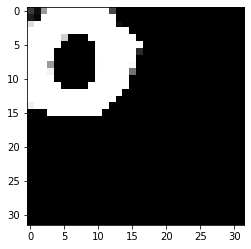

In [47]:
###### Training ######
#train_images, train_labels, test_images, test_labels
import gc
gc.collect()

#By tuning LR helps with eliminating big jumps of the accuracy.
#Its important to make SMALL adjustment to LR so you can find the right spot
params_values, accuracy_history = train(train_images, train_labels, 60, 0.008, 0) #0.05 stable LR

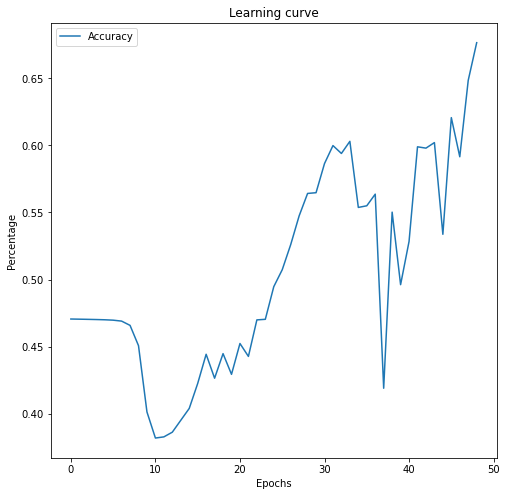

In [48]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(accuracy_history, label="Accuracy")
#plt.plot(results.history["val_loss"], label="val_loss")
#plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Percentage")
plt.legend();

Calculating Forward step . . .
Cost: 0.39   -   Accuracy: 67.66%


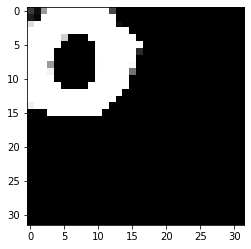

In [49]:
###### Prediction ######
Validate(train_images, train_labels, params_values);
pass
"""
Yt = test_labels.T
temp1 = []
for i in range(Yt.shape[1]):
        for j in range(Yt.shape[0]):
            if(Yt[j][i]==1):
                temp1.append(j)
Yt=np.array(temp1)
Y_test_hat, _ = full_forward_propagation(np.transpose(test_images), params_values, NN_ARCHITECTURE)#multiple?!

Yht = np.array(Y_test_hat.T)
#x_log=np.log( np.exp(Yh) / np.sum(np.exp(Yh), axis = 1) )  #(60000,10) , we need to add along columns so we get sum of 1 on every example-row
num = np.exp(Yht)
den = np.sum(np.exp(Yht), axis = 1)
for i in range(Yht.shape[0]): #60000
                #for j in range(Yh.shape[1]): #10
                Yht[i][:] = np.log(num[i][:] / den[i])  

#cost = get_cost_value(Yht, Yt)

#cost_history.append(cost)
accuracy = get_accuracy_value(Y_test_hat, test_labels.T)
#accuracy_history.append(accuracy)
print("Accuracy: {:.5f}%".format( accuracy*100))
"""
pass